In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import utils

In [2]:
anr_tag = 'FOAK'
wacc = utils.WACC
cambium_scenario = 'MidCase'
year = 2024
results_path = f'./results/raw_results_anr_{anr_tag}_h2_wacc_{str(wacc)}.xlsx'
clean_save_path = f'./results/clean_results_anr_{anr_tag}_h2_wacc_{str(wacc)}.xlsx'

In [3]:
save_fig_path = f'./results/refining_anr_{anr_tag}_h2'

In [4]:
df = pd.read_excel(results_path, sheet_name='refining')
df.sort_values(by=['Breakeven price ($/MMBtu)'], inplace=True)
df.reset_index(inplace=True)
df.drop(columns=['index'], inplace=True)

In [5]:
anr_param = pd.read_excel('ANRs.xlsx', sheet_name=anr_tag)

### Compute deployed power at each refinery and cumulative deployed ANR capacity

In [6]:
anr_thermal_power = anr_param[['Power in MWe', 'Reactor']]
anr_thermal_power
df = df.merge(anr_thermal_power, how='inner', left_on=['ANR type'], right_on=['Reactor'])
df.sort_values(by=['Breakeven price ($/MMBtu)'], inplace=True)
df['Deployed Power (MWe)'] = df['Power in MWe']*df['# ANR modules']
df['ANR Nameplate Capacity (GWe)'] = df['Deployed Power (MWe)'].cumsum()/1000
df['Cum h2 dem (t/day)'] = df['H2 Dem. (kg/day)'].cumsum()/1000
df['Cum h2 dem (%)'] = 100*df['H2 Dem. (kg/day)'].cumsum()/df['H2 Dem. (kg/day)'].sum()

### Compute cumulative number of viable refineries and ANR modules

In [7]:
df['Viable ANR modules count'] = df['# ANR modules'].cumsum()
df.reset_index(inplace=True)
df.drop(columns=['index'], inplace=True)
df['Viable ANR refineries count'] = df.index+1

### Compute avoided carbon emissions 

In [8]:
SMR_carbon_intensity = 11.888 #kgCO2eq/kgH2
df['Ann. avoided CO2 emissions (MMT-CO2/year)'] = (df['H2 Dem. (kg/day)']*365*SMR_carbon_intensity - df['Ann. CO2 emissions (kgCO2eq/year)'])/1e9
df['Viable avoided emissions (MMT-CO2/year)'] = df['Ann. avoided CO2 emissions (MMT-CO2/year)'].cumsum()
df[['Breakeven price ($/MMBtu)', 'Viable avoided emissions (MMT-CO2/year)']].tail(110)

,Breakeven price ($/MMBtu),Viable avoided emissions (MMT-CO2/year)
0,-11.174919,1.253608
1,-10.980947,2.473596
2,-10.969492,3.638401
3,-10.777155,4.016940
4,-10.149601,4.564334
5,-9.999979,4.907573
6,-9.840213,5.244053
7,-9.748265,5.765597
8,-9.421709,6.267549
9,-9.355916,6.765710


In [9]:
res_be = pd.read_csv('./results/res_be_refining.csv', index_col='RES')
def find_be_h2_demand(df, percentage):
  indleft = df['Cum h2 dem (%)'].sub(percentage).abs().idxmin()
  be = df['Breakeven price ($/MMBtu)'][indleft]
  return be
for percent in [10, 25, 50, 75, 90]:
  res_be.loc[str(percent), 'Breakeven price ($/MMBtu)'] = find_be_h2_demand(df, percent)
res_be

,Breakeven price ($/MMBtu)
RES,
Grid PEM,34.837997
Wind subsidized,37.250875
Wind unsubsidized,43.861501
Solar PEC,49.579692
Solar PV-E,50.901817
SMR 89% CCUS,12.758507
10,-11.174919
25,-10.969492
50,-9.355916


In [10]:
sheetn= 'refining'
excelf = './results/res_be_comparison.xlsx'
try:
  with pd.ExcelFile(excelf, engine='openpyxl') as xls:
    with pd.ExcelWriter(excelf, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
      res_be.to_excel(writer, sheet_name=sheetn)
except FileNotFoundError:
  res_be.to_excel(excelf, sheet_name=sheetn)

### Compute revenues from electricity cogeneration

In [11]:
df = utils.compute_cogen(df, surplus_cap_col_name='Surplus ANR Cap. (MWe)', state_col_name='state', \
                         cambium_scenario=cambium_scenario, year = year)
df['Net Revenues with H2 PTC with elec ($/year)'] = df['Net Revenues with H2 PTC ($/year)']+df['Electricity revenues ($/y)']

### Save clean version of results


In [12]:
df_clean = df[["id", 'state',  'latitude', 'longitude','H2 Dem. (kg/day)', 'HTSE', 'ANR type', '# ANR modules', \
               'Electricity revenues ($/y)','Net Revenues ($/year)','Net Revenues with H2 PTC ($/year)', 'Breakeven CAPEX ($/MWe)', 'Cost red CAPEX BE',\
                'Ann. avoided CO2 emissions (MMT-CO2/year)', 'Breakeven price ($/MMBtu)',\
                    'Viable avoided emissions (MMT-CO2/year)','Net Revenues with H2 PTC with elec ($/year)']]

df_clean['H2 Dem. (kg/day)'] /=1e3
df_clean['HTSE'] = df_clean['HTSE'].apply(lambda x: int(x))
df_clean['H2 Dem. (kg/day)'] = df_clean['H2 Dem. (kg/day)'].apply(lambda x:np.round(x,1))
df_clean['Net Revenues ($/year)'] /=1e6
df_clean['Avoided cost of CO2 ($/ton)'] = df_clean['Net Revenues ($/year)']/df_clean['Ann. avoided CO2 emissions (MMT-CO2/year)']
df_clean['Avoided cost of CO2 ($/ton)'] = df_clean['Avoided cost of CO2 ($/ton)'].apply(lambda x:np.round(np.abs(x),1))
df_clean['Net Revenues ($/year)'] = df_clean['Net Revenues ($/year)'].apply(lambda x: np.abs(np.round(x,1)))
df_clean['Ann. avoided CO2 emissions (MMT-CO2/year)']= df_clean['Ann. avoided CO2 emissions (MMT-CO2/year)'].apply(lambda x: np.round(x,1))
df_clean['Breakeven price ($/MMBtu)'] = df_clean.apply(lambda x:np.round(x['Breakeven price ($/MMBtu)'],1), axis=1)
df_clean.rename(columns={'RH2 Dem. (kg/day)': 'Demand (MT H2/day)',
                         'ANR type': 'ANR', 
                         '# ANR modules': '#'}, inplace=True)
df_clean.sort_values(by=['Breakeven price ($/MMBtu)'], inplace=True)


C:\Users\mgarrou\AppData\Local\Temp\ipykernel_9144\1962802301.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['H2 Dem. (kg/day)'] /=1e3
C:\Users\mgarrou\AppData\Local\Temp\ipykernel_9144\1962802301.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['HTSE'] = df_clean['HTSE'].apply(lambda x: int(x))
C:\Users\mgarrou\AppData\Local\Temp\ipykernel_9144\1962802301.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

In [13]:
sheet_name = 'refining'
excel_file = clean_save_path
try:
# Load the existing Excel file
  with pd.ExcelFile(excel_file, engine='openpyxl') as xls:
      # Check if the sheet exists
      if sheet_name in xls.sheet_names:
          # If the sheet exists, replace the data
          with pd.ExcelWriter(excel_file, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
              df.to_excel(writer, sheet_name=sheet_name)
      else:
          # If the sheet doesn't exist, create a new sheet
          with pd.ExcelWriter(excel_file, engine='openpyxl', mode='a') as writer:
              df.to_excel(writer, sheet_name=sheet_name)
except FileNotFoundError:
    # If the file doesn't exist, create a new one and write the DataFrame to it
    df.to_excel(excel_file, sheet_name=sheet_name)

### Plots

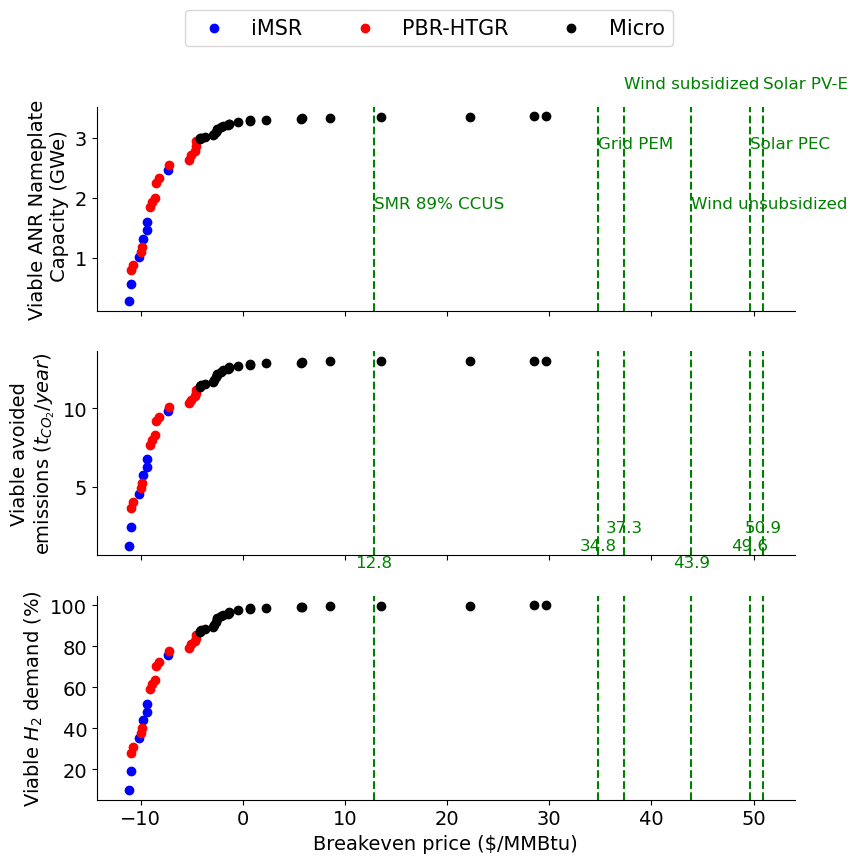

In [14]:
#Use latex font
#plt.rcParams['text.usetex'] = True
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['font.size'] = 14

# Create subplots
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(9, 9))

# Get unique ANR types and assign colors
anr_types = df['ANR type'].unique()

colors = ['blue', 'red', 'black']  # Adjust the colors according to the unique ANR types
# Initialize empty handles for legend
handles = []
# Plotting the data as scatter plots with different colors for each ANR type
labels = {'ANR Nameplate Capacity (GWe)': 'Viable ANR Nameplate\n Capacity (GWe)',
            'Viable avoided emissions (MMT-CO2/year)': 'Viable avoided\n'r'emissions ($t_{CO_2}/year$)',
            'Cum h2 dem (%)':r'Viable $H_2$ demand (%)'}
for i, col in enumerate(['ANR Nameplate Capacity (GWe)', 'Viable avoided emissions (MMT-CO2/year)', 'Cum h2 dem (%)']):
    for anr_type, color in zip(anr_types, colors):
        subset = df[df['ANR type'] == anr_type]
        axs[i].scatter(subset['Breakeven price ($/MMBtu)'], subset[col], color=color, label=f'{anr_type}')
    axs[i].set_ylabel(labels[col])

    # Remove the top and right spines
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)

    # Adding vertical lines
    res_be = pd.read_csv('./results/res_be_refining.csv')
    res_be.sort_values(by='Breakeven price ($/MMBtu)', inplace=True)
    res_be['Breakeven price ($/MMBtu)'] = res_be.apply(lambda x:np.round(x['Breakeven price ($/MMBtu)'],1), axis=1)
    ng_vertical_lines = [6.4, 13, 40]
    ng_labels = ['US NG\navg 2022', 'CA NG\ndelivered 2022', 'EU NG\n 2022']
    res_vert_lines = list(res_be['Breakeven price ($/MMBtu)'])
    #for line in ng_vertical_lines:
     #   axs[i].axvline(x=line, linestyle='--', color='grey')
    for l,line in enumerate(res_vert_lines):
        axs[i].axvline(x=line, linestyle='--',color='green')

res_labels = res_be['RES']
count = 0
for x, label in zip(res_vert_lines, res_labels):
    axs[0].text(x, (axs[0].get_ylim()[1]+axs[0].get_ylim()[0])/2+np.mod(count,3), label, fontsize=12, color='green')
    axs[1].text(x, axs[1].get_ylim()[0]+1.1*np.mod(count,3), str(x), color='green', fontsize=12, va='top',ha='center')
    count+=1

# Setting the title and labels
plt.xlabel('Breakeven price ($/MMBtu)')
#fig.text(0.5, 0.07, 'Breakeven price ($/MMBtu)', ha='center')

# Add a common legend for all subplots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=len(anr_types))
plt.savefig(save_fig_path+'.png')

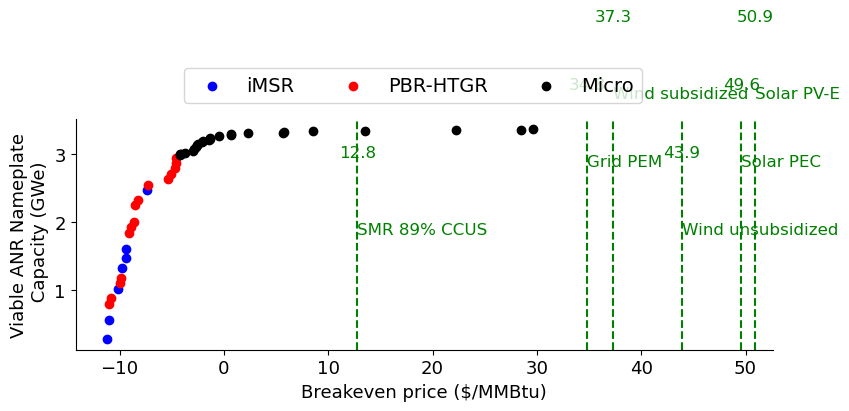

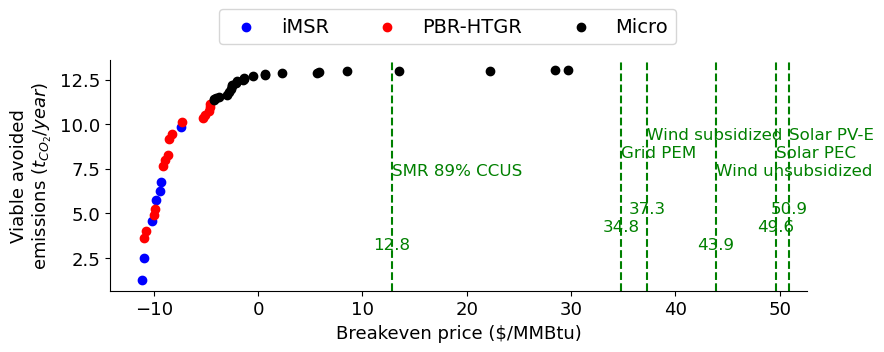

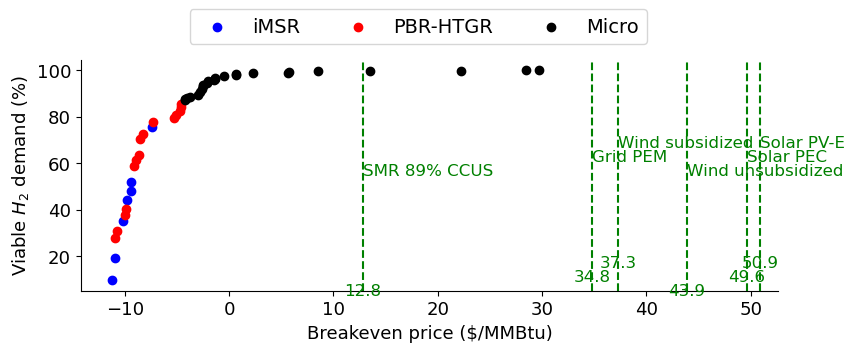

In [15]:
#Use latex font
#plt.rcParams['text.usetex'] = True
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['font.size'] = 13
labels = {'ANR Nameplate Capacity (GWe)': ['Viable ANR Nameplate\n Capacity (GWe)', 'capacity'],
            'Viable avoided emissions (MMT-CO2/year)': ['Viable avoided\n'r'emissions ($t_{CO_2}/year$)', 'emission'],
            'Cum h2 dem (%)':[r'Viable $H_2$ demand (%)', 'h2_demand']}

def plot_against_be(df, col_name, y_label, save_label):
    anr_types = df['ANR type'].unique()
    colors = ['blue', 'red', 'black'] 
    fig, axs = plt.subplots(figsize=(9, 3))
    for anr_type, color in zip(anr_types, colors):
        subset = df[df['ANR type'] == anr_type]
        axs.scatter(subset['Breakeven price ($/MMBtu)'], subset[col_name], color=color, label=f'{anr_type}')
    axs.set_ylabel(y_label)
    axs.set_xlabel('Breakeven price ($/MMBtu)')
    axs.spines['top'].set_visible(False)
    axs.spines['right'].set_visible(False)

    # Adding vertical lines and labels for competing RES 
    res_be = pd.read_csv('./results/res_be_refining.csv')
    res_be.sort_values(by='Breakeven price ($/MMBtu)', inplace=True)
    res_be['Breakeven price ($/MMBtu)'] = res_be.apply(lambda x:np.round(x['Breakeven price ($/MMBtu)'],1), axis=1)
    res_vert_lines = list(res_be['Breakeven price ($/MMBtu)'])
    for l,line in enumerate(res_vert_lines):
        axs.axvline(x=line, linestyle='--',color='green')
        res_labels = res_be['RES']
    count = 0
    for x, label in zip(res_vert_lines, res_labels):
        if save_label =='h2_demand': modulo=6 
        else: modulo=1
        axs.text(x, (axs.get_ylim()[1]+axs.get_ylim()[0])/2+modulo*np.mod(count,3), label, fontsize=12, color='green')
        axs.text(x, axs.get_ylim()[0]+modulo*np.mod(count,3)+3, str(x), color='green', fontsize=12, va='top',ha='center')
        count+=1
        # Setting the title and labels
    axs.set_xlabel('Breakeven price ($/MMBtu)')
    handles, labels = axs.get_legend_handles_labels()
    fig.legend(handles, labels,  bbox_to_anchor=(.5,1.08),loc='upper center', ncol=len(anr_types))
    fig.savefig(save_fig_path+'_'+save_label+'.png', bbox_inches='tight')

for col_name, label_list in labels.items():
    plot_against_be(df, col_name, y_label=label_list[0], save_label=label_list[1])
